      ApplicationDate  Age  AnnualIncome  CreditScore EmploymentStatus  \
9913       2045-02-21   49        168849          605       Unemployed   
15856      2061-05-31   33        157300          609         Employed   
14490      2057-09-03   45        101703          655    Self-Employed   
6635       2036-03-02   35         81060          609    Self-Employed   
3431       2027-05-25   56        127188          587         Employed   

      EducationLevel  Experience  LoanAmount  LoanDuration MaritalStatus  ...  \
9913          Master          25       43090            36       Married  ...   
15856         Master          10       23670            60       Married  ...   
14490      Doctorate          22       16009            60       Married  ...   
6635     High School          14       14902            48       Married  ...   
3431       Associate          32       12341            36        Single  ...   

       MonthlyIncome UtilityBillsPaymentHistory  JobTenure  NetWorth

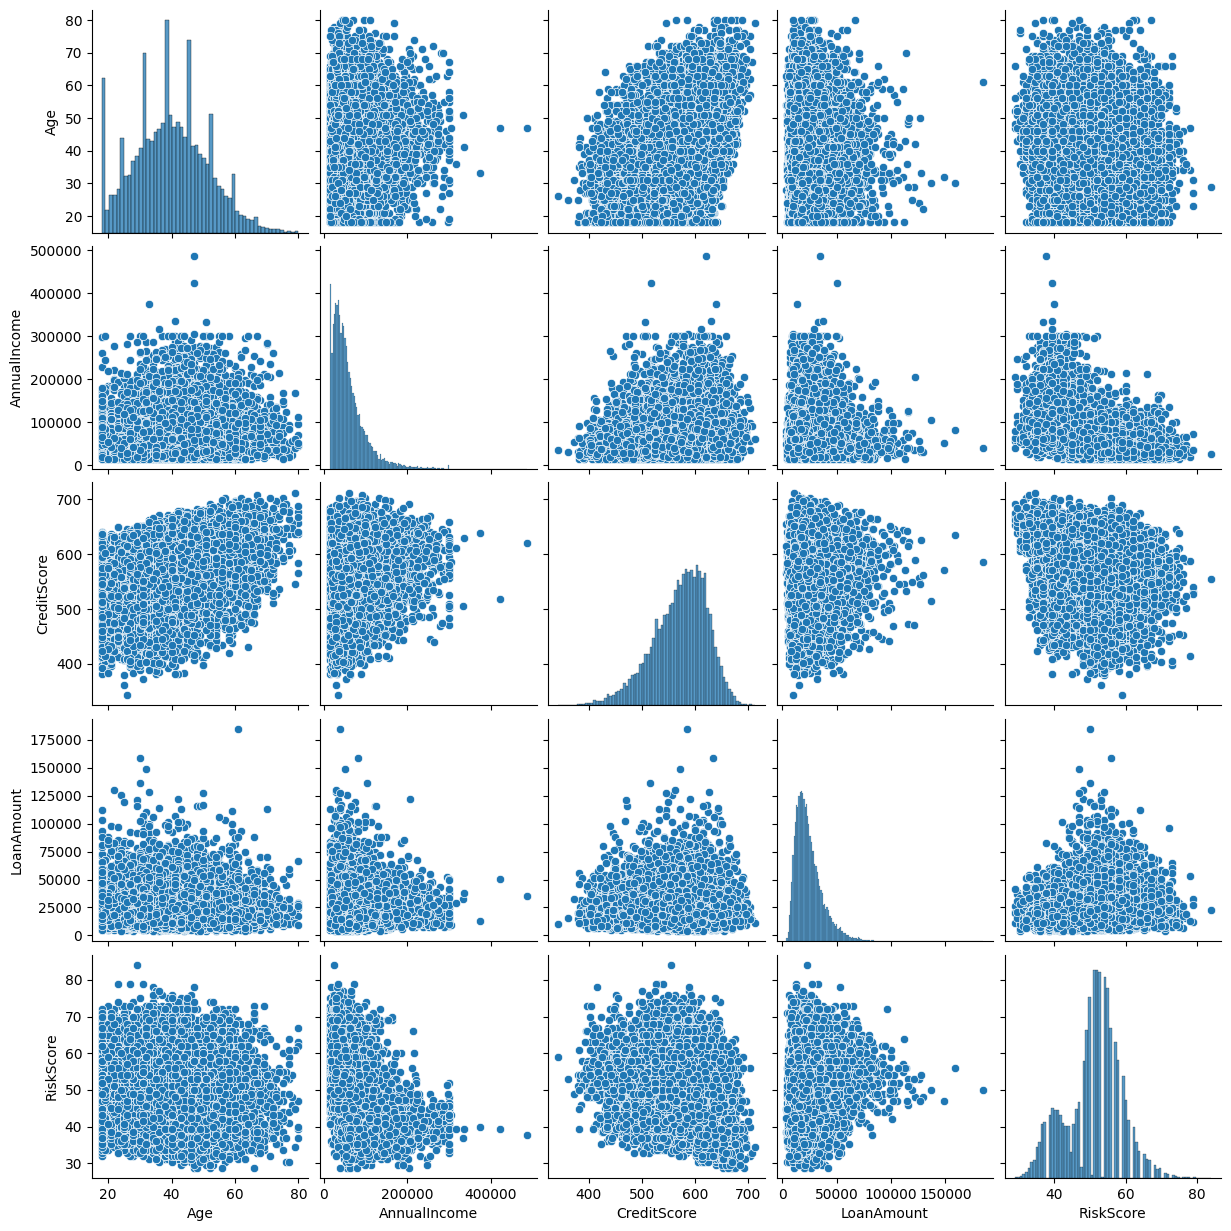

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier


# Charger les données
df = pd.read_csv('./archive/Loan.csv')

df_approved = df[df.LoanApproved == 1]
df_not_approved = df[df.LoanApproved == 0]
df_sample = pd.concat([df_approved.sample(1478), df_not_approved.sample(2000)])



# Afficher les premières lignes du dataset
print(df_sample.head())

# Statistiques descriptives
print(df_sample.describe())

# Visualisation des données
sns.pairplot(df[['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'RiskScore']])
plt.show()



In [58]:
print(df_sample['LoanApproved'].value_counts())

# pourcentage de chaque classe
print(df_sample['LoanApproved'].value_counts(normalize=True))


LoanApproved
0    2000
1    1478
Name: count, dtype: int64
LoanApproved
0    0.575043
1    0.424957
Name: proportion, dtype: float64


# Nettoyage des données

In [59]:
# Identifier les valeurs manquantes
missing_values = df_sample.isnull().sum()
print(missing_values)

# Liste des colonnes que nous gardons
cols_to_keep = ['Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus', 'LoanAmount', 'LoanDuration', 
                'DebtToIncomeRatio', 'PreviousLoanDefaults', 'PaymentHistory', 'HomeOwnershipStatus', 
                'MaritalStatus', 'MonthlyDebtPayments']

# Créer un nouveau DataFrame avec uniquement ces colonnes
df_filtered = df_sample[cols_to_keep]

# Encoder les variables catégorielles pour EmploymentStatus, HomeOwnershipStatus, et MaritalStatus
df_encoded = pd.get_dummies(df_filtered, columns=['EmploymentStatus', 'HomeOwnershipStatus', 'MaritalStatus'], drop_first=True)

print(df_encoded.head())

ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
EmploymentStatus              0
EducationLevel                0
Experience                    0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
NetWorth                      0
BaseInterestRate              0
Interest

In [60]:
from sklearn.preprocessing import MinMaxScaler

# Colonnes à normaliser
cols_to_scale = ['AnnualIncome', 'LoanAmount', 'DebtToIncomeRatio', 'MonthlyDebtPayments', 'CreditScore']

scaler = MinMaxScaler()
df_encoded[cols_to_scale] = scaler.fit_transform(df_encoded[cols_to_scale])

print(df_encoded[cols_to_scale].head())


       AnnualIncome  LoanAmount  DebtToIncomeRatio  MonthlyDebtPayments  \
9913       0.428878    0.271643           0.088530             0.602778   
15856      0.396684    0.137807           0.401516             0.076667   
14490      0.241698    0.085009           0.082590             0.165000   
6635       0.184153    0.077380           0.642480             0.377222   
3431       0.312742    0.059730           0.173735             0.339444   

       CreditScore  
9913      0.677711  
15856     0.689759  
14490     0.828313  
6635      0.689759  
3431      0.623494  


# Division du dataset et modélisation

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Diviser les données en données d'entraînement et de test
X = df_encoded
y = df_sample['LoanApproved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un classifieur Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_features=2)

# Entraîner le modèle
rf.fit(X_train, y_train)

# Prédire les valeurs sur les données de test
y_pred = rf.predict(X_test)

from sklearn.metrics import accuracy_score

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')

Accuracy: 0.8663793103448276


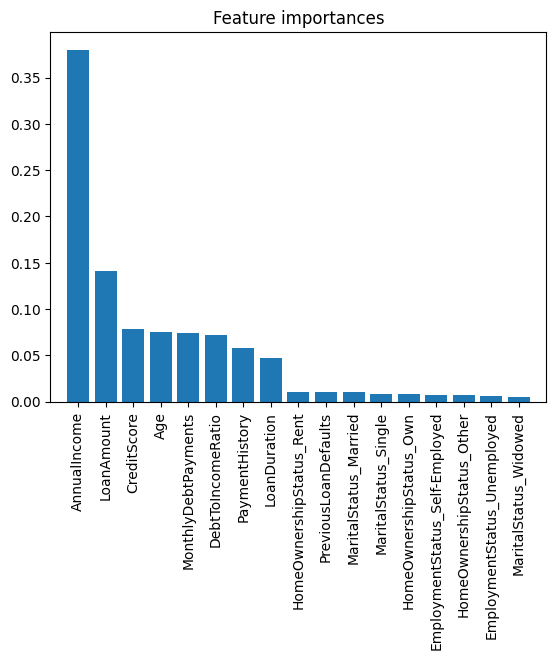

In [62]:
#afficher les features importances
import numpy as np


importances = rf.feature_importances_
features = X.columns

indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


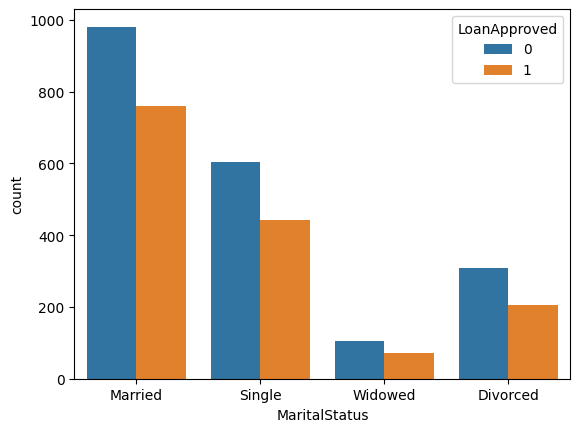

In [63]:
#home ownership status
df_sample['HomeOwnershipStatus'].value_counts()

# do a graph to show the distribution of the loan approval by home ownership status
sns.countplot(x='MaritalStatus', hue='LoanApproved', data=df_sample)

plt.show()




# Prediction

In [64]:
from sklearn.metrics import confusion_matrix
import shap


# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

from sklearn.metrics import classification_report

# Rapport de classification
class_report = classification_report(y_test, y_pred)
print(class_report)

# # Explainer SHAP
# explainer = shap.TreeExplainer(rf)

# # Calculer les SHAP values
# shap_values = explainer.shap_values(X_test)

# # Afficher les SHAP values
# shap.summary_plot(shap_values[1], X_test, plot_type='bar')

# # Afficher les SHAP values pour un individu
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])





[[345  36]
 [ 57 258]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       381
           1       0.88      0.82      0.85       315

    accuracy                           0.87       696
   macro avg       0.87      0.86      0.86       696
weighted avg       0.87      0.87      0.87       696



# Regression

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Modèle de régression (RiskScore)
regressor = RandomForestRegressor(random_state=42)

# Diviser les données en données d'entraînement et de test
X_reg = df_encoded
y_reg = df_sample['RiskScore']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

regressor.fit(X_train_reg, y_train_reg)

# Prédictions sur le test set
y_pred_reg = regressor.predict(X_test_reg)

# Calcul des métriques d'évaluation
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f'Mean Absolute Error (MAE): {mae}')



Mean Absolute Error (MAE): 4.0994913793103445


In [66]:
# 

In [67]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# # Définir la grille de recherche
# param_distribs = {
#     'n_estimators': randint(low=1, high=200),
#     'max_depth': randint(low=1, high=20),
# }

# # Initialiser le modèle
# clf = RandomForestClassifier(random_state=42)

# # Initialiser la recherche aléatoire
# rnd_search = RandomizedSearchCV(clf, param_distributions=param_distribs, n_iter=10, cv=5, scoring='accuracy', random_state=42)
# rnd_search.fit(X_train_class, y_train_class)

# # Meilleurs paramètres
# print(rnd_search.best_params_)
# print(rnd_search.best_score_)
# print(rnd_search.best_estimator_)



In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Initialiser le classifieur
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Calculer les scores de validation croisée
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

print(f'Scores: {scores}')

print(f'Mean Accuracy: {scores.mean()}')

print(f'Standard Deviation: {scores.std()}')


Scores: [0.84201077 0.87073609 0.85431655 0.85611511 0.87769784]
Mean Accuracy: 0.8601752709143279
Standard Deviation: 0.012643811926861957


In [72]:
# export the model
import joblib

clf.fit(X_train, y_train)

# Save the model
joblib.dump(clf, 'loan_approval_model.pkl')
with open('loan_approval_model_columns.pkl', 'wb') as f:
    joblib.dump(X_train.columns, f)
joblib.dump(regressor, 'risk_score_model.pkl')


['risk_score_model.pkl']

In [70]:
# Compter les valeurs de LoanApproved
loan_approval_counts = df['LoanApproved'].value_counts()

# pourcentage de prêts approuvés
loan_approval_percentage = loan_approval_counts[1] / (loan_approval_counts[0] + loan_approval_counts[1])

print(f'Pourcentage de prêts approuvés: {loan_approval_percentage:.2f}')


Pourcentage de prêts approuvés: 0.24


In [92]:
# test the model
# Load the model
clf = joblib.load('loan_approval_model.pkl')
with open('loan_approval_model_columns.pkl', 'rb') as f:
    columns = joblib.load(f)
regressor = joblib.load('risk_score_model.pkl')

# Create a sample input
input_data = {
    'Age': 25,
    'AnnualIncome': 50000,
    'CreditScore': 600,
    'LoanAmount': 10000,
    'LoanDuration': 12,
    'DebtToIncomeRatio': 0.3,
    'PreviousLoanDefaults': 0,
    'PaymentHistory': 0,
    'MonthlyDebtPayments': 500,
    'EmploymentStatus_Employed': 1,
    'EmploymentStatus_Unemployed': 0,
    'HomeOwnershipStatus_Own': 0,
    'HomeOwnershipStatus_Rent': 1,
    'MaritalStatus_Married': 0,
    'MaritalStatus_Single': 1
}

# Convert the input to a DataFrame
input_df = pd.DataFrame([input_data], columns=columns)

# Make a prediction
prediction = clf.predict(input_df)[0]
print(f'Loan Approval Prediction: {prediction}')


Loan Approval Prediction: 1
